# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum

In [4]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



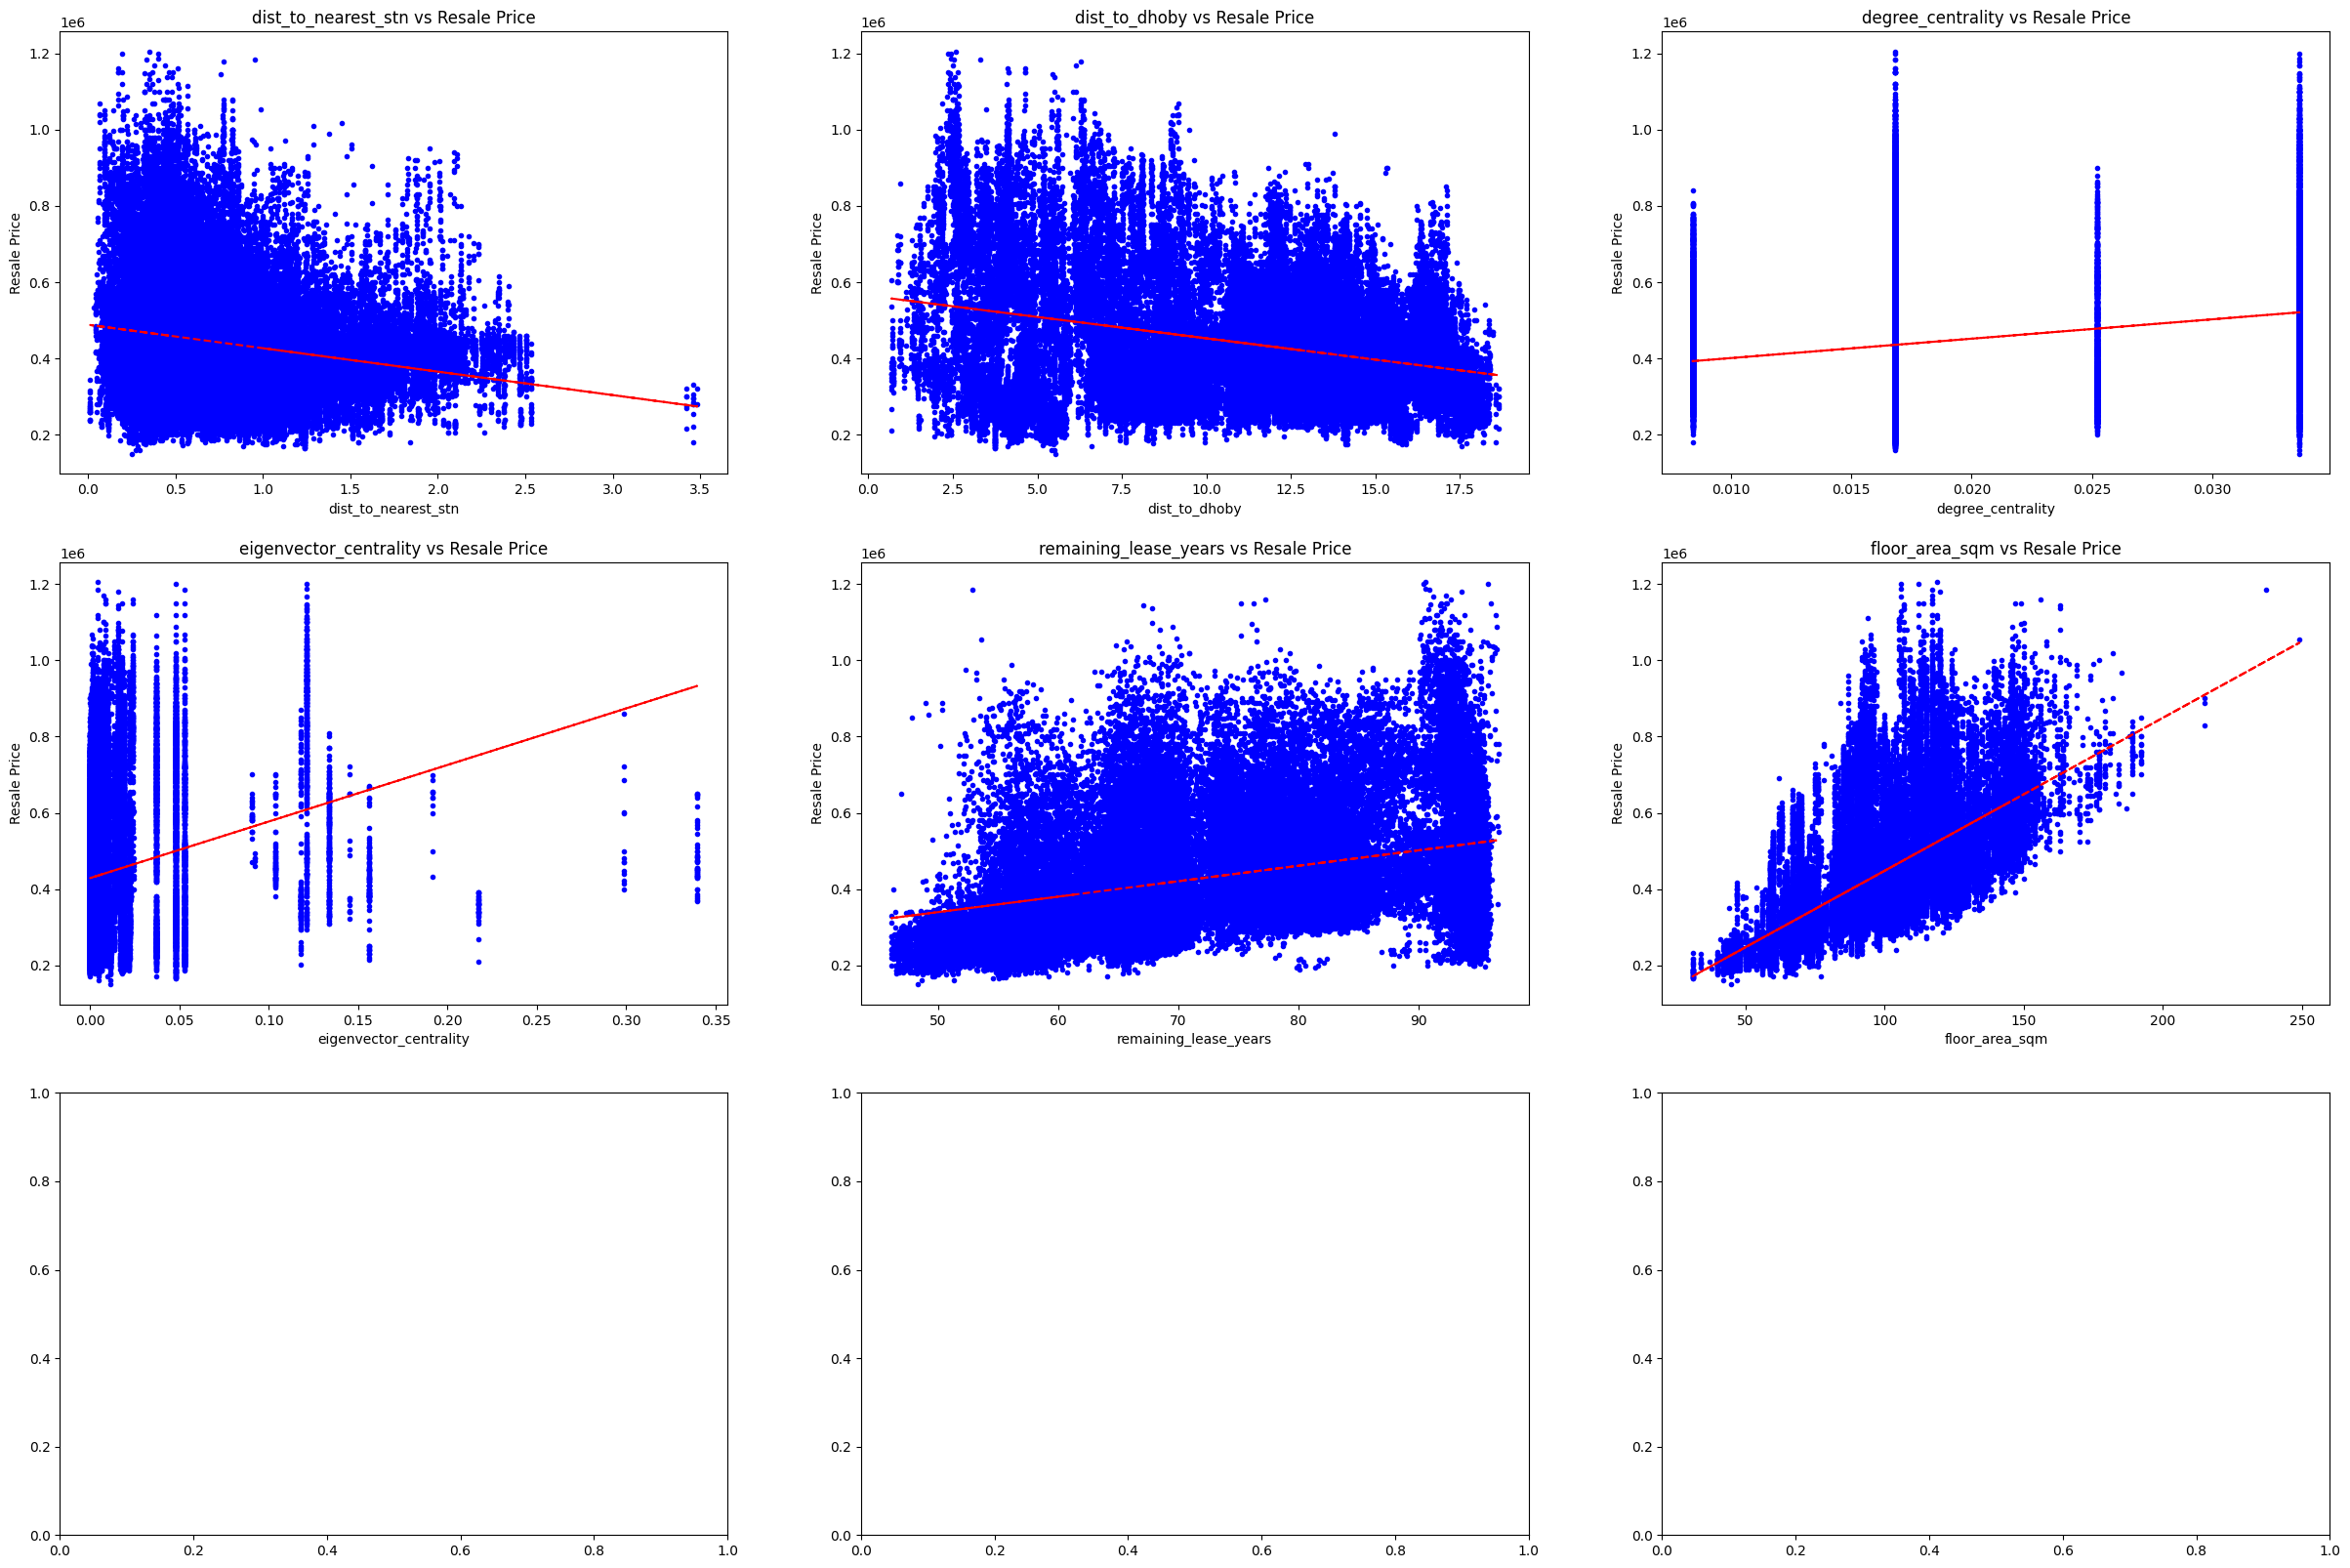

In [5]:
# YOUR CODE HERE
from common_utils import preprocess_dataset, EarlyStopper, CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pylab as plt

df = pd.read_csv('hdb_price_prediction.csv')

# print(f"df length before dropping 2022-23: {len(df)}")
df = df[df.year != 2022]
df = df[df.year != 2023]
# print(f"df length after dropping 2022-23: {len(df)}")

df = df.drop(['full_address', 'nearest_stn'], axis=1)
# print(f"df:\n{df}")

# print(f"test:\n{test}")

continuous_cols = ["dist_to_nearest_stn", "dist_to_dhoby", "degree_centrality", "eigenvector_centrality", "remaining_lease_years", "floor_area_sqm"]
categorical_cols = [ "month", "town", "flat_model_type", "storey_range"]

df = df.drop(categorical_cols, axis=1)

train = df[df.year < 2020]
val = df[df.year == 2020]
test = df[df.year == 2021]

y_train = train['resale_price'].values
X_train = train.drop(['resale_price', 'year'], axis=1).to_numpy()

y_val = val['resale_price'].values
X_val = val.drop(['resale_price', 'year'], axis=1).to_numpy()

y_test = test['resale_price'].values
X_test = test.drop(['resale_price', 'year'], axis=1).to_numpy()

temp = df.drop(['resale_price', 'year'], axis=1)
# print(f"columns: {temp.columns}")
def plot_all(X_train, y_train):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 20))

    for i, (ax, col) in enumerate(zip(axes.flat, temp.columns)):
        # print(f"i: {i}")
        x = X_train[:, i]
        pf = np.polyfit(x, y_train, 1)
        p = np.poly1d(pf)

        ax.plot(x, y_train, 'b.')
        ax.plot(x, p(x), "r--")

        ax.set_title(col + ' vs Resale Price')
        ax.set_xlabel(col)
        ax.set_ylabel('Resale Price')

plot_all(X_train, y_train)

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [6]:
# YOUR CODE HERE
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_train = torch.tensor(X_train, dtype=torch.float)

y_val = torch.tensor(y_val, dtype=torch.float).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float)

y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float)

print(f"X_train length: {len(X_train[0])}\nX_train:\n{X_train}")

X_train length: 6
X_train:
tensor([[1.0073e+00, 7.0060e+00, 1.6807e-02, 6.2428e-03, 6.1333e+01, 4.4000e+01],
        [1.2714e+00, 7.9838e+00, 1.6807e-02, 6.2428e-03, 6.0583e+01, 6.7000e+01],
        [1.0697e+00, 9.0907e+00, 1.6807e-02, 2.4586e-03, 6.2417e+01, 6.7000e+01],
        ...,
        [4.4587e-01, 1.3498e+01, 1.6807e-02, 9.6841e-04, 7.1500e+01, 1.6400e+02],
        [5.5277e-01, 1.3598e+01, 1.6807e-02, 9.6841e-04, 7.1500e+01, 1.6400e+02],
        [4.7588e-01, 1.2739e+01, 1.6807e-02, 9.6841e-04, 6.7083e+01, 1.4500e+02]])


3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [8]:
# YOUR CODE HERE
class FFN(nn.Module):
    def __init__(self, no_features, no_hidden, no_output):
        super().__init__()
        self.relu_stack = nn.Sequential(
            # Input to hidden layer 1
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            # hidden layer 1 to hidden layer 2
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            # hidden layer 2 to hidden layer 3
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            # hidden layer 3 to output layer
            nn.Linear(no_hidden, no_output),
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits


def dataloader_maker(mini_x, mini_y, batch_size, shuffle):
    """
    This function is to take the x_train / x_val and y_train / y_val and convert it to a DataLoader object with its batch sizes.
    """
    data = CustomDataset(mini_x, mini_y)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def intialise_loaders(X_train_scaled, y_train, X_val_scaled, y_val):
    # YOUR CODE HERE
    """
    Created dataset for train and test, then load them into a dataloader.
    """
    train_dataloader = dataloader_maker(X_train_scaled, y_train, 1024, True)
    val_dataloader = dataloader_maker(X_val_scaled, y_val, 1024, True)
    return train_dataloader, val_dataloader


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= size
    return train_loss

def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss = 0
    with torch.no_grad():
        for x, y, in dataloader:
            pred = model(x)

            val_loss += loss_fn(pred, y).item()
    val_loss /= size
    return val_loss

def training(model, train_dataloader, val_dataloader, optimizer, loss_fn, early_stopper, no_epochs):
    train_loss = []
    val_loss = []
    for epoch in range(no_epochs):
        train_loss_ = train_loop(train_dataloader, model, loss_fn, optimizer)
        val_loss_ = val_loop(val_dataloader, model, loss_fn)

        train_loss.append(train_loss_)
        val_loss.append(val_loss_)

        if epoch % 20 == 0:
            print(f"Epoch: {epoch}")
            print(f"Train Loss: {train_loss_}\tValidation Loss: {val_loss_}")

        if early_stopper.early_stop(val_loss_):
            print(f"Early Stopping at epoch {epoch}!")
            break
    return train_loss, val_loss


In [9]:
train_dataloader, val_dataloader = intialise_loaders(X_train, y_train, X_val, y_val)
no_features = len(X_train[0])
no_hidden = 5
no_output = 1
lr = 0.001
no_epochs = 200
batch_size = 1024

model = FFN(no_features, no_hidden, no_output)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
early_stopper = EarlyStopper(patience=3, min_delta=100000)

train_loss, val_loss = training(model, train_dataloader, val_dataloader, optimizer, loss_fn, early_stopper, no_epochs)

C:\Users\nsupr\CZ4042 NN & DL Assignment\common_utils.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(
C:\Users\nsupr\CZ4042 NN & DL Assignment\common_utils.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


Epoch: 0
Train Loss: 212809116.22486222	Validation Loss: 225356980.83507055
Epoch: 20
Train Loss: 192826939.47503006	Validation Loss: 202857601.70754516
Epoch: 40
Train Loss: 70967189.8545358	Validation Loss: 73720127.23956591
Epoch: 60
Train Loss: 28648573.887881108	Validation Loss: 29400501.17548149
Epoch: 80
Train Loss: 28494790.243439436	Validation Loss: 29052148.437009394
Epoch: 100
Train Loss: 28382148.00543266	Validation Loss: 28970283.166302063
Epoch: 120
Train Loss: 28218562.2110308	Validation Loss: 28821221.39304251
Epoch: 140
Train Loss: 28017891.333531074	Validation Loss: 28676536.294084847
Epoch: 160
Train Loss: 27789053.44627441	Validation Loss: 28479992.862351477
Epoch: 180
Train Loss: 27646060.415442497	Validation Loss: 28402674.33963883


In [10]:
from sklearn.metrics import mean_squared_error

pred = model(X_test)
err = np.sqrt(mean_squared_error(pred.detach().numpy(), y_test.detach().numpy()))
print(f"Test Error: {err}")

Test Error: 158401.1875


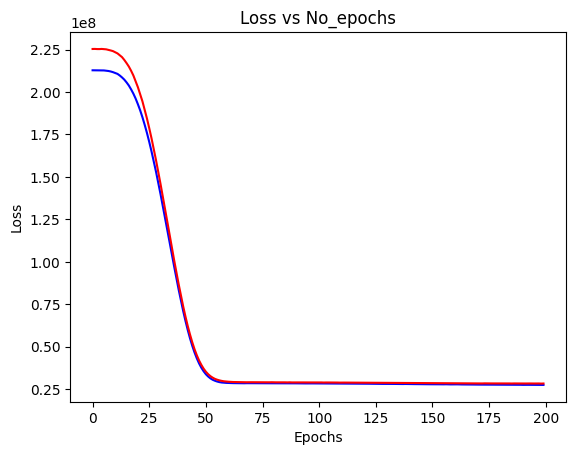

In [11]:
def plot_loss(no_epochs, train_loss, val_loss):
    fig = plt.figure()
    plt.plot(range(len(train_loss)), train_loss, label='train', color="blue")
    plt.plot(range(len(val_loss)), val_loss, label='validation', color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs No_epochs")
    plt.show()

plot_loss(no_epochs, train_loss, val_loss)

In [12]:
# Plotting Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

X_test_sample = X_test[:5000]
X_train_sample = X_train
y_test_sample = y_test[:5000]
y_train_sample = y_train

def scores(model, X_test_sample, X_train_sample, y_test_sample, y_train_sample):
    sal = Saliency(model)
    ixg = InputXGradient(model)
    ig = IntegratedGradients(model)
    gs = GradientShap(model)
    fa = FeatureAblation(model)

    # ig_nt_attr_test = sal.attribute(X_test_sample)
    # dl_attr_test = ixg.attribute(X_test_sample)
    sal_attr_test = sal.attribute(X_test_sample)
    ixg_attr_test = ixg.attribute(X_test_sample)
    ig_attr_test = ig.attribute(X_test_sample, n_steps=50)
    gs_attr_test = gs.attribute(X_test_sample, X_train_sample)
    fa_attr_test = fa.attribute(X_test_sample)

    # prepare attributions for visualization

    x_axis_data = np.arange(X_test_sample.shape[1])
    # x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))
    x_axis_data_labels = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality',
        'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

    sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
    sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

    ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
    ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

    ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

    gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
    gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

    fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
    fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)


    width = 0.14
    legends = ['Saliency', 'InputXGradient', 'IntegratedGradients', 'GradientShap', 'FeatureAblation']

    plt.figure(figsize=(20, 10))

    ax = plt.subplot()
    ax.set_title('Comparing input feature importances across multiple algorithms')
    ax.set_ylabel('Attributions')

    FONT_SIZE = 16
    plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
    plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
    plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
    plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

    # print(f"x_axis_data:\n{x_axis_data}")
    # print(f"sal_nt_attr_test\n{sal_attr_test_sum.shape}")

    ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
    ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
    ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
    ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
    ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
    ax.autoscale_view()
    plt.tight_layout()

    ax.set_xticks(x_axis_data + 0.5)
    ax.set_xticklabels(x_axis_data_labels)

    plt.legend(legends, loc=3)
    plt.show()

C:\Users\nsupr\anaconda3\envs\tensorflow\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


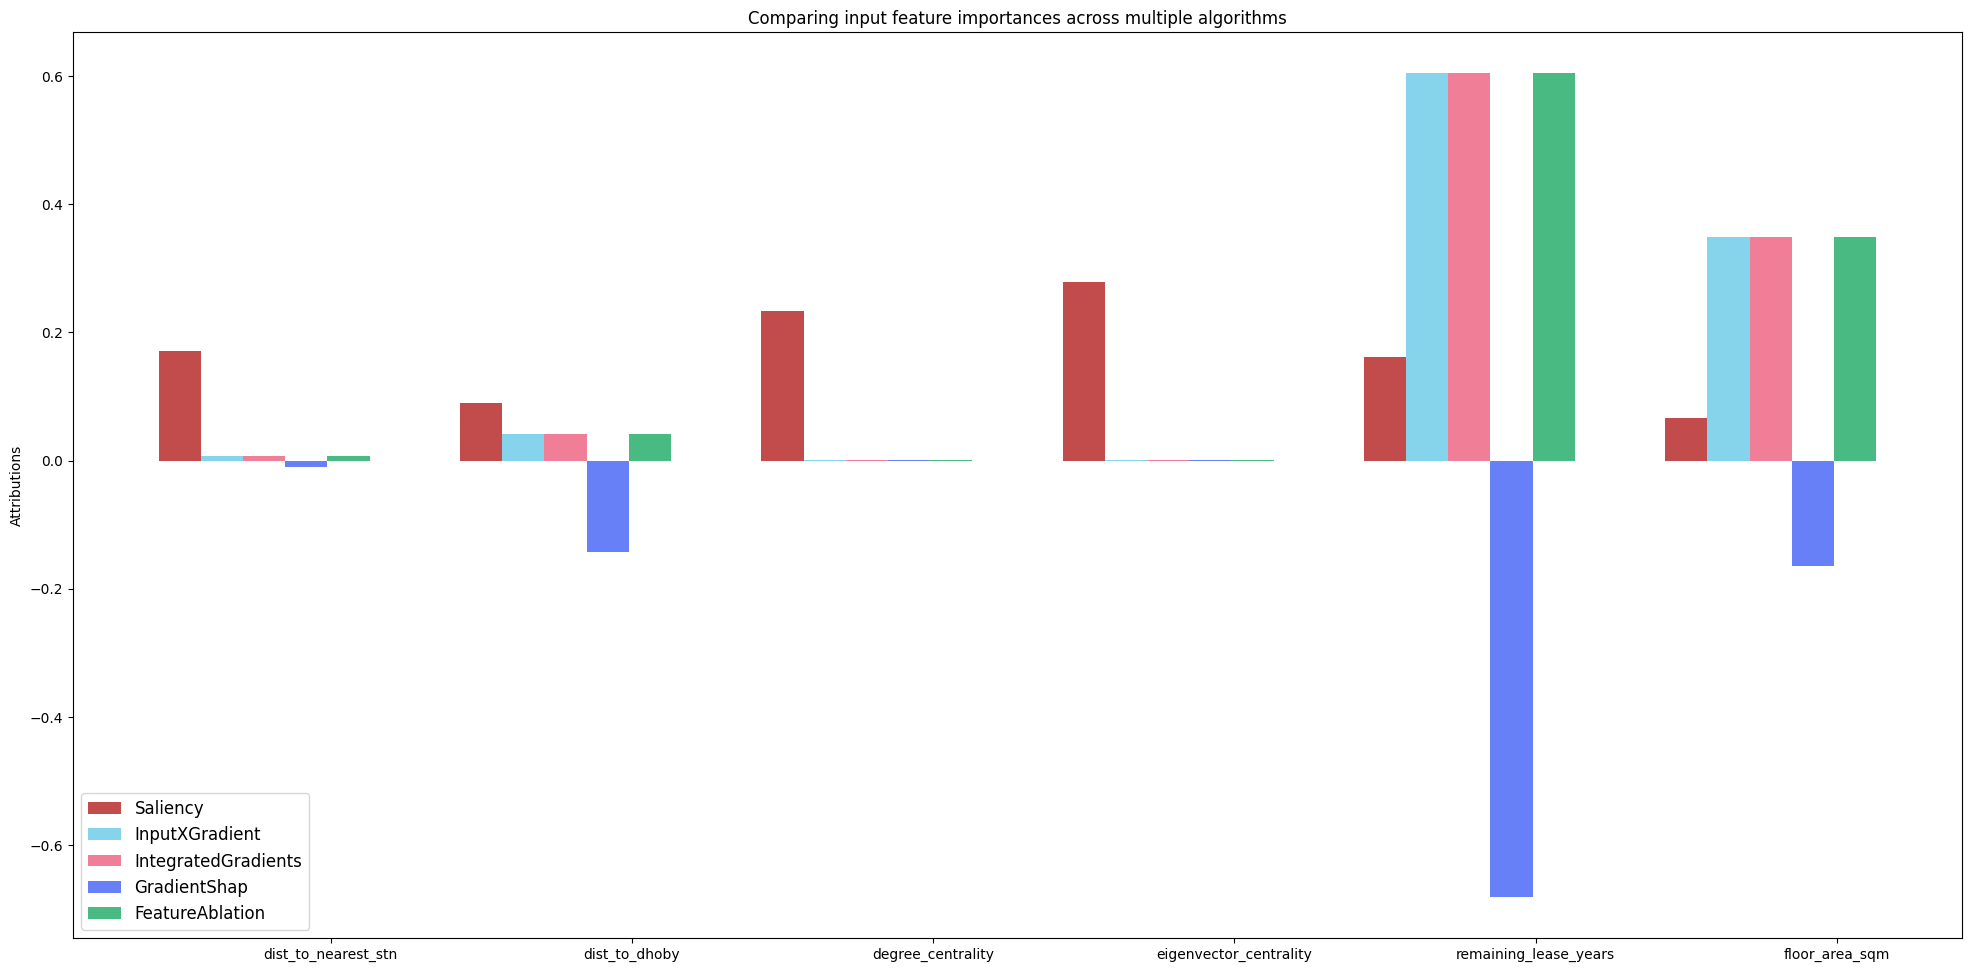

In [13]:
scores(model, X_test_sample, X_train_sample, y_test_sample, y_train_sample)

In [14]:
train_scaled = df[df.year < 2020]
val_scaled = df[df.year == 2020]
test_scaled = df[df.year == 2021]

# Did not scale y, but just name scaled for this 2nd part.
y_train_scaled = train_scaled['resale_price'].values
pre_X_train_scaled = train_scaled.drop(['resale_price', 'year'], axis=1).to_numpy()

y_val_scaled = val_scaled['resale_price'].values
pre_X_val_scaled = val_scaled.drop(['resale_price', 'year'], axis=1).to_numpy()

y_test_scaled = test_scaled['resale_price'].values
pre_X_test_scaled = test_scaled.drop(['resale_price', 'year'], axis=1).to_numpy()

X_train_scaled, X_val_scaled = preprocess_dataset(pre_X_train_scaled, pre_X_val_scaled)
_, X_test_scaled = preprocess_dataset(pre_X_train_scaled, pre_X_test_scaled)

y_train_scaled = torch.tensor(y_train_scaled, dtype=torch.float).view(-1, 1)
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float)

y_val_scaled = torch.tensor(y_val_scaled, dtype=torch.float).view(-1, 1)
X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float)

y_test_scaled = torch.tensor(y_test_scaled, dtype=torch.float).view(-1, 1)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float)

In [15]:
train_dataloader_scaled, val_dataloader_scaled = intialise_loaders(
    X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled
)
no_features = len(X_train_scaled[0])
no_hidden = 5
no_output = 1
lr = 0.001
no_epochs = 200
batch_size = 1024

model_scaled = FFN(no_features, no_hidden, no_output)
optimizer = torch.optim.Adam(model_scaled.parameters(), lr=lr)
loss_fn = nn.MSELoss()
early_stopper = EarlyStopper(patience=3, min_delta=100000)

train_loss_scaled, val_loss_scaled = training(
    model_scaled, train_dataloader_scaled, val_dataloader_scaled, optimizer, loss_fn, early_stopper, no_epochs
)

C:\Users\nsupr\CZ4042 NN & DL Assignment\common_utils.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(
C:\Users\nsupr\CZ4042 NN & DL Assignment\common_utils.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
C:\Users\nsupr\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 1])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\nsupr\anaconda3

Epoch: 0
Train Loss: 212748948.1160841	Validation Loss: 225308763.53759706
Epoch: 20
Train Loss: 207886110.56877467	Validation Loss: 219852858.5067559
Epoch: 40
Train Loss: 163906368.026976	Validation Loss: 172408299.28983828
Epoch: 60
Train Loss: 88059005.79196653	Validation Loss: 91504257.68558314
Epoch: 80
Train Loss: 44085577.88219867	Validation Loss: 45508059.91644147
Epoch: 100
Train Loss: 34712452.35012567	Validation Loss: 36056414.205979496
Epoch: 120
Train Loss: 30209877.016282372	Validation Loss: 31304180.469952386
Epoch: 140
Train Loss: 27120260.00243533	Validation Loss: 27953842.48513705
Epoch: 160
Train Loss: 25251568.625692744	Validation Loss: 25804772.152189765
Epoch: 180
Train Loss: 24277081.744071685	Validation Loss: 24737106.25865397


In [16]:
pred = model_scaled(X_test_scaled)
err = np.sqrt(mean_squared_error(pred.detach().numpy(), y_test_scaled.detach().numpy()))
print(f"Scaled Test Error: {err}")

Scaled Test Error: 180221.453125


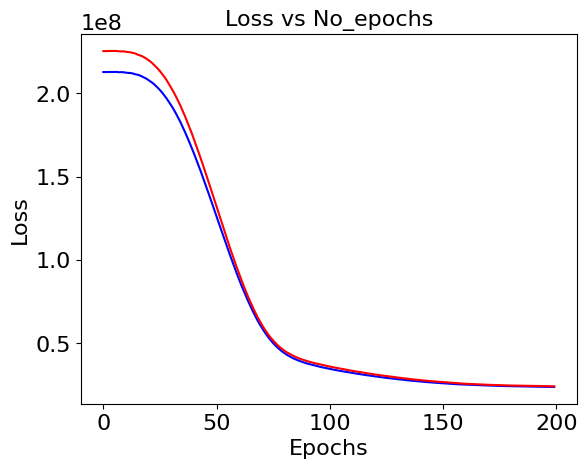

In [17]:
plot_loss(no_epochs, train_loss_scaled, val_loss_scaled)

C:\Users\nsupr\anaconda3\envs\tensorflow\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


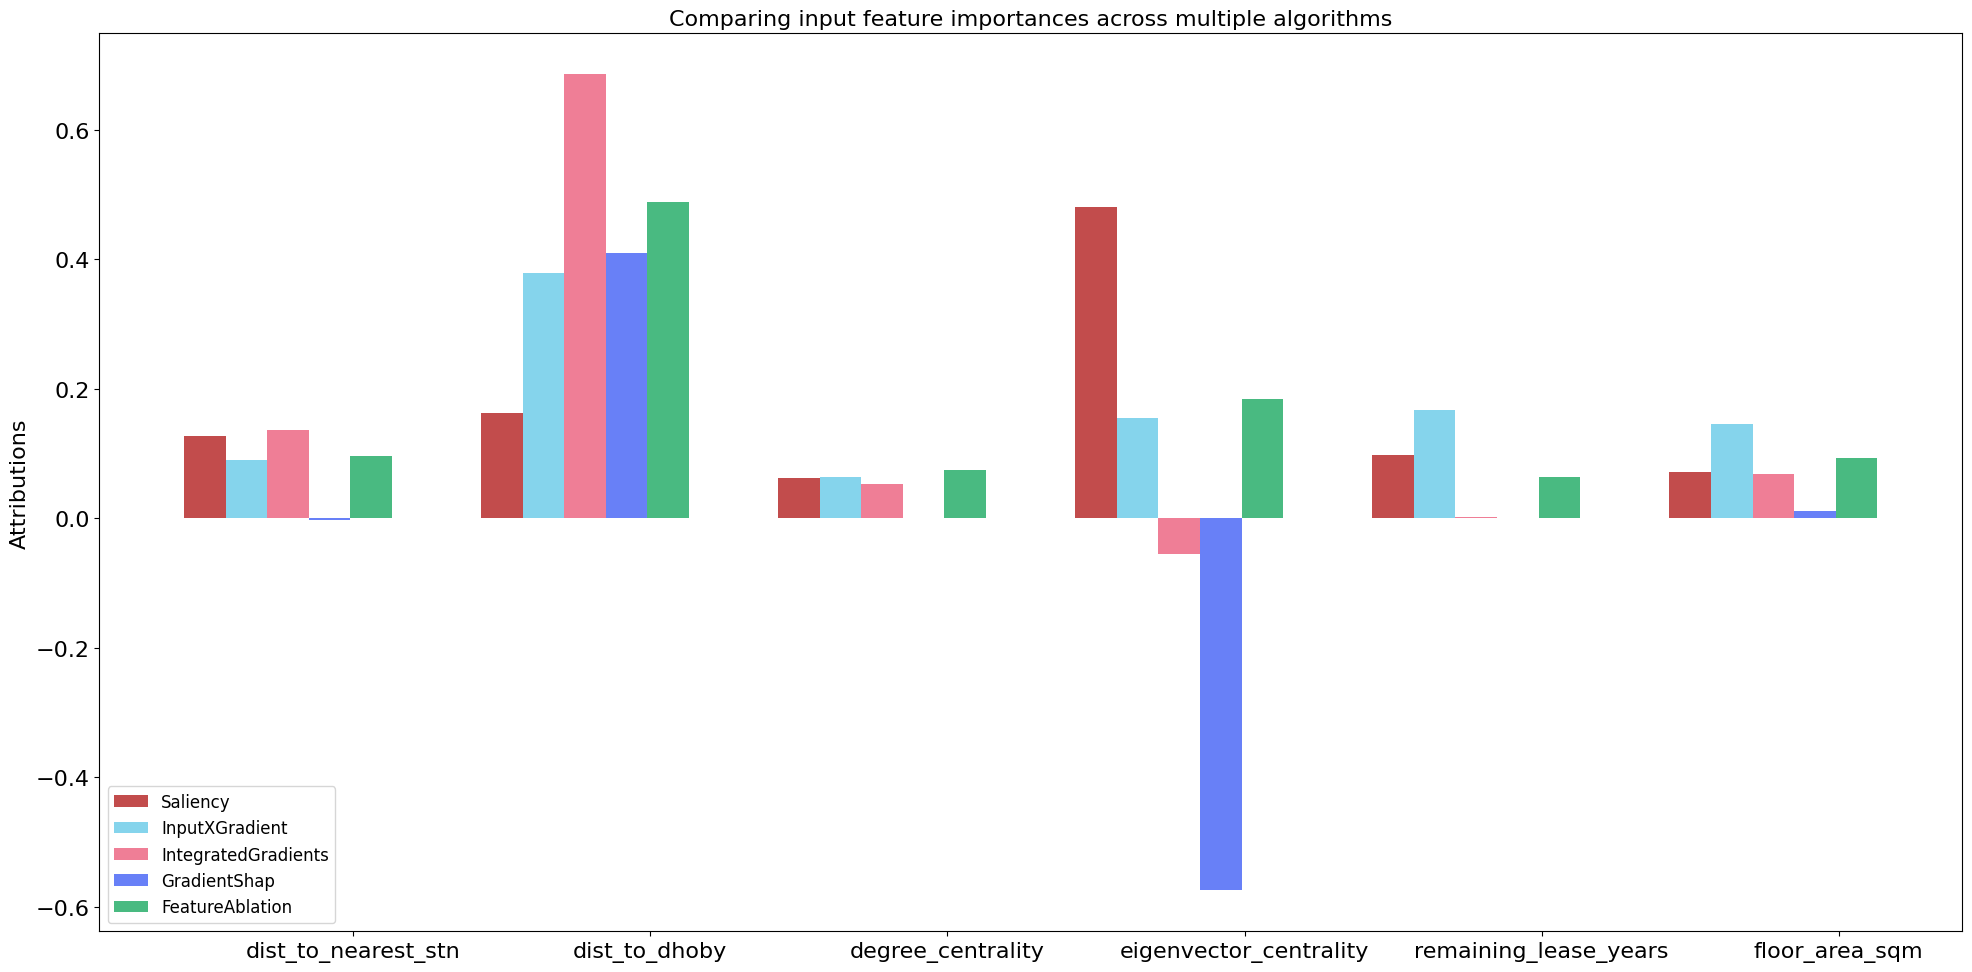

In [18]:
X_test_sample_scaled = X_test_scaled[:5000]
X_train_sample_scaled = X_train_scaled
y_test_sample_scaled = y_test_scaled[:5000]
y_train_sample_scaled = y_train_scaled

scores(model_scaled, X_test_sample_scaled, X_train_sample_scaled, y_test_sample_scaled, y_train_sample_scaled)

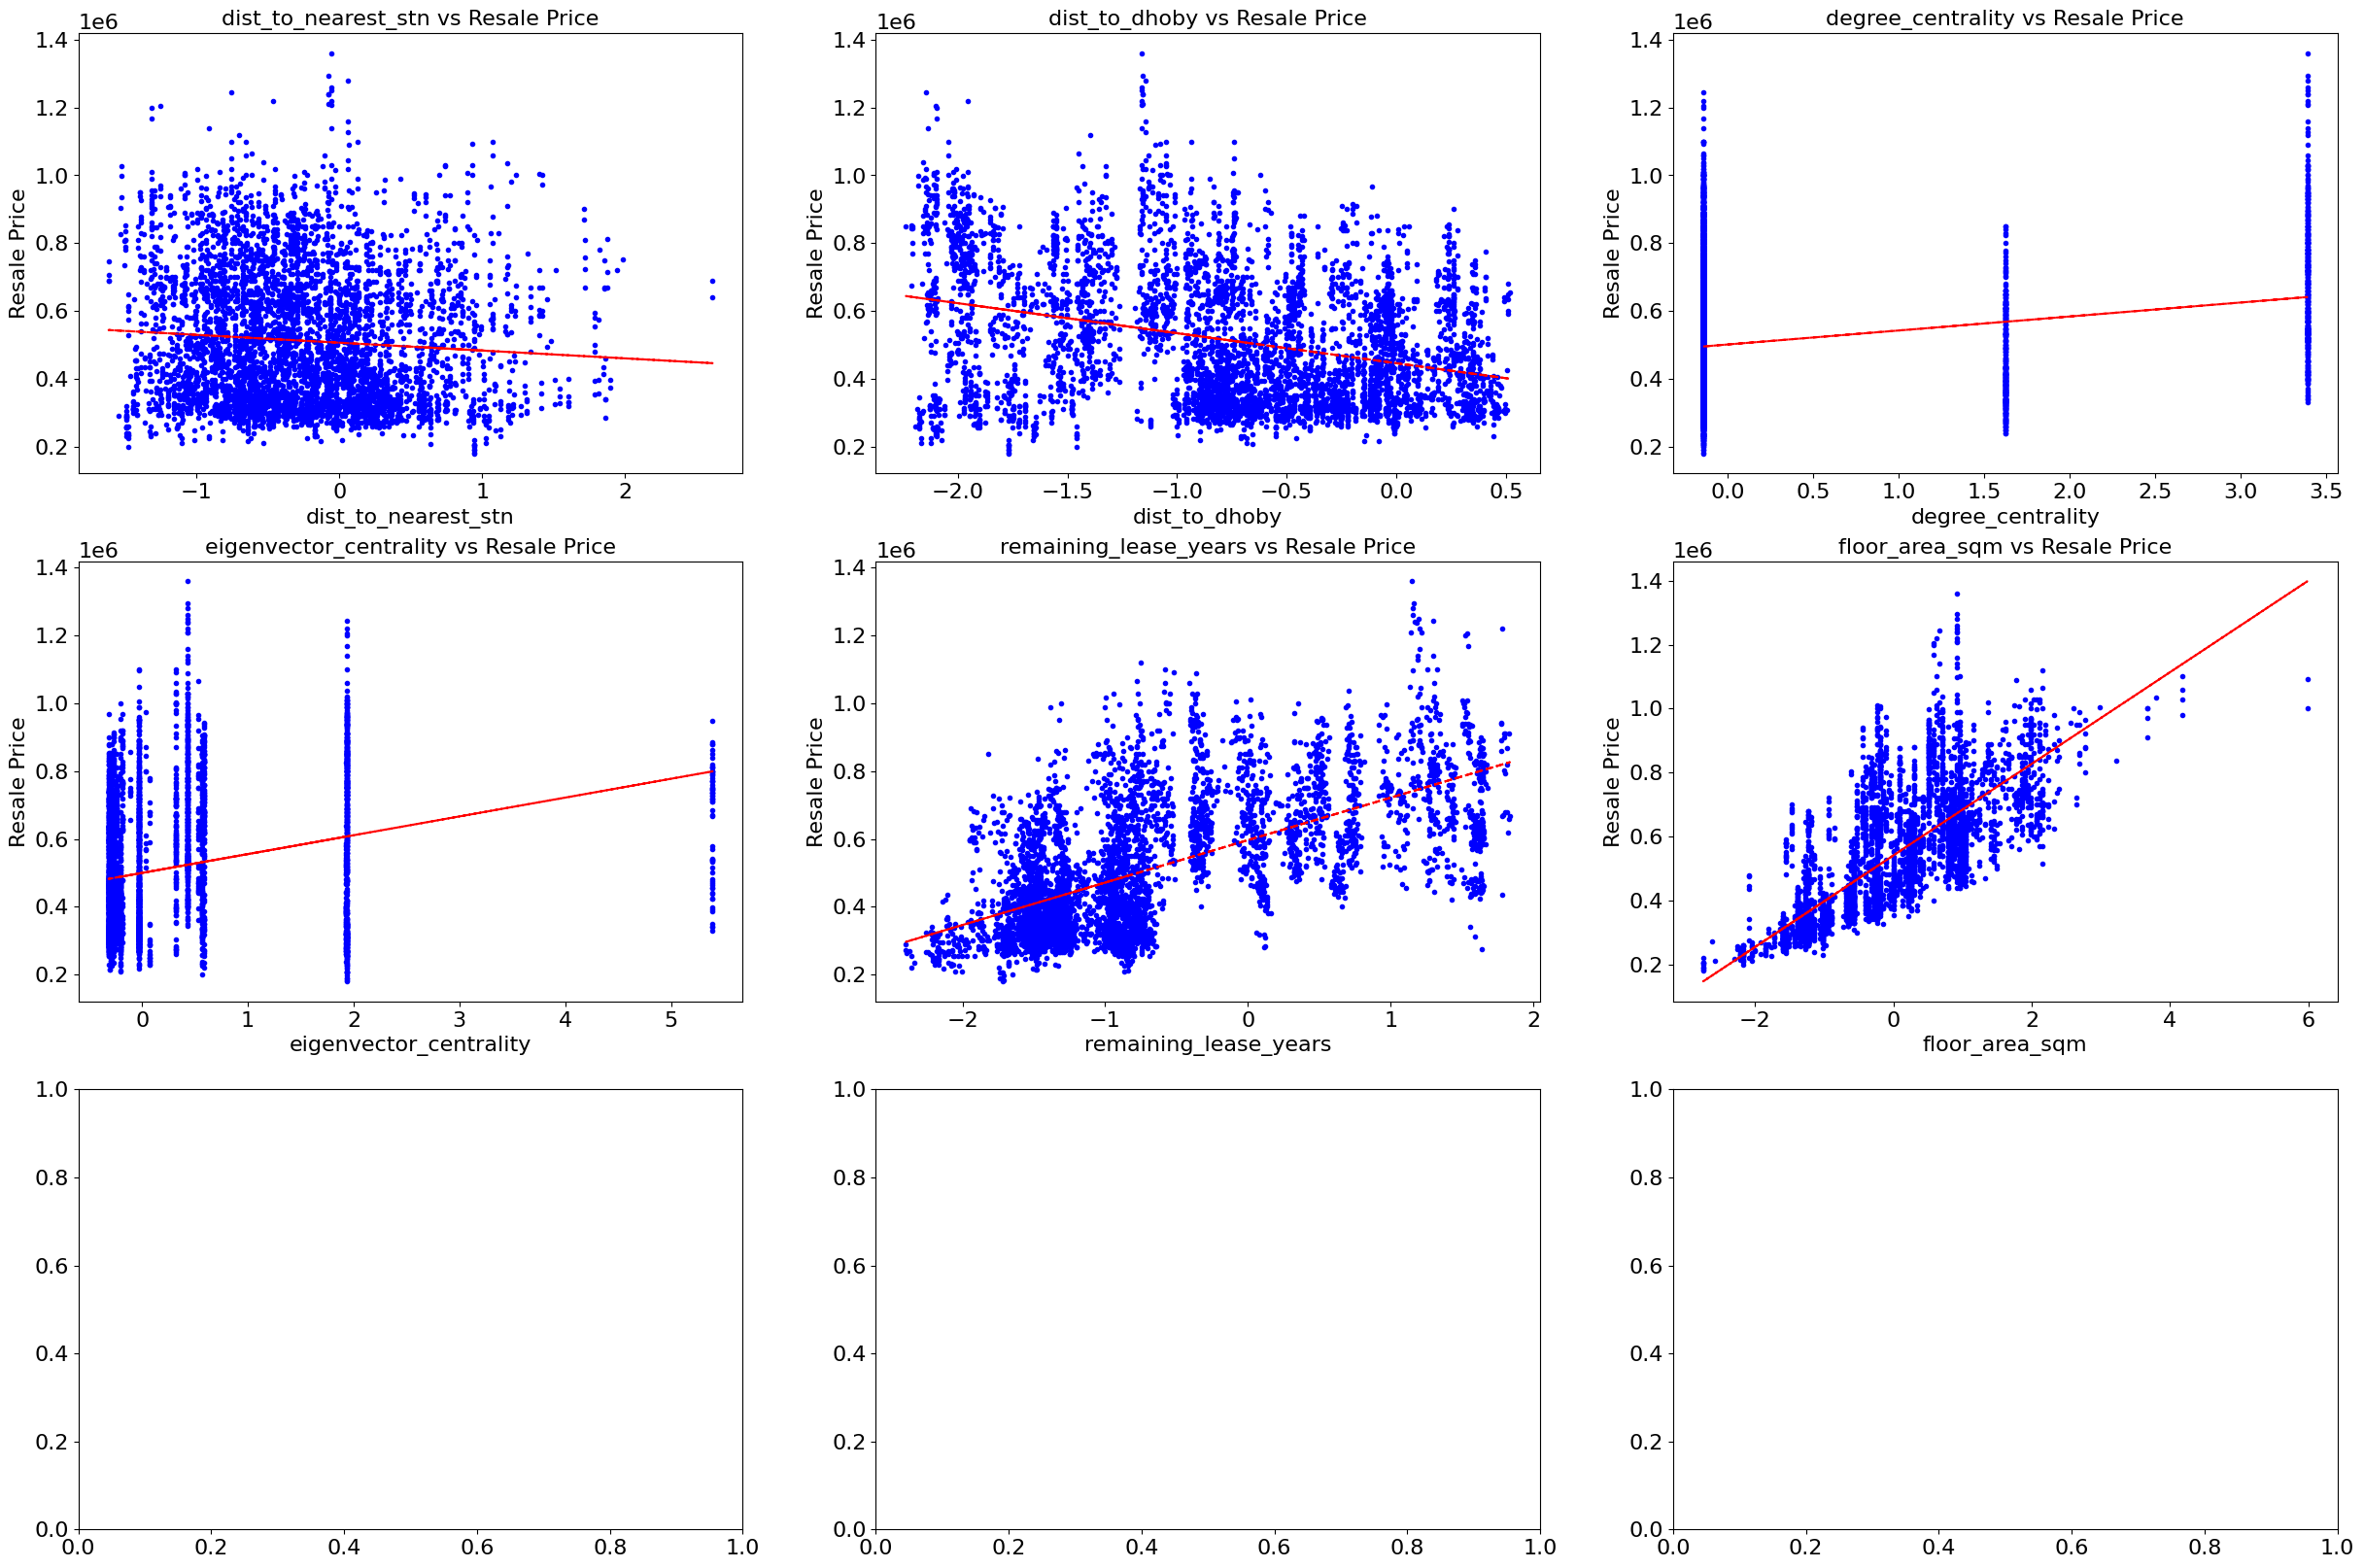

In [19]:
# print(f"X_test_sample_scaled:\n{X_test_sample_scaled.detach().numpy()}")
y_detached = y_test_sample_scaled.detach().numpy().reshape(len(y_test_sample_scaled), 1)
y_detached = y_detached.flatten()
# print(f"X_test_sample_scaled:\n{y_detached}")
plot_all(X_test_sample_scaled.detach().numpy(), y_detached)

In [20]:
explanation = '''
The default baseline used here is my x_train. Before scaling the dataset, GradientSHAP score was rather distinct for most of the columns, as we can see a definite value for most features such as dist_to_dhoby.

What i can observe after scaling is that the column such as degree_centrality and eigenvector_centrality provided some result after scaling when it did not before scaling. This is probably due to the values being scaled from a range of (0, 0.04) to having a wider range from (-0.2, 3.5). GradientSHAP could calculate a larger gradient w.r.t. the baseline.

For the other columns such as dist_to_nearest_stn, dist_to_dhoby, remaining_lease_years and floor_area_sqm, after scaling, the values remained rather similar. This is because after scaling, the distribution of the data remain rather consistent enough for a gradient to be calculated.

'''
print(explanation)


The default baseline used here is my x_train. Before scaling the dataset, GradientSHAP score was rather distinct for most of the columns, as we can see a definite value for most features such as dist_to_dhoby.

What i can observe after scaling is that the column such as degree_centrality and eigenvector_centrality provided some result after scaling when it did not before scaling. This is probably due to the values being scaled from a range of (0, 0.04) to having a wider range from (-0.2, 3.5). GradientSHAP could calculate a larger gradient w.r.t. the baseline.

For the other columns such as dist_to_nearest_stn, dist_to_dhoby, remaining_lease_years and floor_area_sqm, after scaling, the values remained rather similar. This is because after scaling, the distribution of the data remain rather consistent enough for a gradient to be calculated.




Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


In [22]:
# YOUR ANSWER HERE
Explanation = '''
Saliency and Integrated Gradient (IG) both use the gradient. The difference is that Saliency uses the gradient of output w.r.t. input, whereas IG uses integral of gradient along the path from baseline to input. Integral of gradient along the path from baseline to input refers to the area under the plotted graph of input.

When the data is plotted, we can see that the gradient of the output would vary compared to the gradient of the input. For some continuous columns, the data point results in a nearly linear relationship (like y = x equation) like floor_area_sqm_, in comparison to others like dist_to_nearest_stn_ with a horizontal line (y is nearly constant regardless of x values).

The similarity in scores can occur when the model behaves relatively linearly w.r.t. the baseline and input. We can see this in the graphs like dist_to_nearest_stn_ and degree_centrality_. However, for the others, since the graph seems to be rather linear for output w.r.t. input, they would not have similar scores.

'''
print(explanation)


The default baseline used here is my x_train. Before scaling the dataset, GradientSHAP score was rather distinct for most of the columns, as we can see a definite value for most features such as dist_to_dhoby.

What i can observe after scaling is that the column such as degree_centrality and eigenvector_centrality provided some result after scaling when it did not before scaling. This is probably due to the values being scaled from a range of (0, 0.04) to having a wider range from (-0.2, 3.5). GradientSHAP could calculate a larger gradient w.r.t. the baseline.

For the other columns such as dist_to_nearest_stn, dist_to_dhoby, remaining_lease_years and floor_area_sqm, after scaling, the values remained rather similar. This is because after scaling, the distribution of the data remain rather consistent enough for a gradient to be calculated.




5.Why did Input x Gradients give the same attribution scores as IG?


In [23]:
# YOUR ANSWER HERE
explanation = '''
IXG multiplies model input with gradient of output w.r.t. inputs. It also considers Gradient and input data like IG. When there is a relationship between input and output, they would produce similar results.

For example, before scaling, they produced almost similar results for all continuous columns. This is because they both use the gradient of output multiplied by the input values, but IG just integrates the gradient. This occurred cos they shared similar concepts of the input features. However, after scaling, the integration of the gradient for IG may have changed the input features' values, which resulted in a rather different score.
'''
print(explanation)


IXG multiplies model input with gradient of output w.r.t. inputs. It also considers Gradient and input data like IG. When there is a relationship between input and output, they would produce similar results.

For example, before scaling, they produced almost similar results for all continuous columns. This is because they both use the gradient of output multiplied by the input values, but IG just integrates the gradient. This occurred cos they shared similar concepts of the input features. However, after scaling, the integration of the gradient for IG may have changed the input features' values, which resulted in a rather different score.

